### Part 2 III.2
#### Task: create a spatial interaction model and calibrate the parameter for the cost function (beta) based on the ppulation, jobs, and flows between different places

#### 1. Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt

#### 2.Measures for justifying

In [2]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

#### 3.Import data

In [3]:
OD_data = pd.read_csv("london_flows_OD.csv")
OD_data.info()
#是否考虑空间关系？？？

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [4]:
# Remove Battersea Park station
Battersea_park = OD_data[(OD_data.station_origin == "Battersea Park") | (OD_data.station_destination == "Battersea Park")].index

OD_data_1 = OD_data.drop(Battersea_park)
OD_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61431 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61431 non-null  object 
 1   station_destination  61431 non-null  object 
 2   flows                61431 non-null  int64  
 3   population           61431 non-null  int64  
 4   jobs                 61431 non-null  int64  
 5   distance             61431 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.3+ MB


In [5]:
# Create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number, avoid NaN when creating pivot table later
OD_data_1["TotalNoIntra"] = OD_data_1.apply(lambda x: 0 if x['station_origin'] == x['station_destination'] else x['flows'], axis=1)
#set the number to a very small number
OD_data_1["offset"]= OD_data_1.apply(lambda x: 0.0000000001 if x['station_origin'] == x['station_destination'] else 0, axis=1)
OD_data_1["offset"].value_counts()#18行数据是自己到自己的
offset_sub = OD_data_1[OD_data_1.offset == 0.0000000001].index
OD_data_1 = OD_data_1.drop(offset_sub)
OD_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61413 entries, 0 to 61473
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61413 non-null  object 
 1   station_destination  61413 non-null  object 
 2   flows                61413 non-null  int64  
 3   population           61413 non-null  int64  
 4   jobs                 61413 non-null  int64  
 5   distance             61413 non-null  float64
 6   TotalNoIntra         61413 non-null  int64  
 7   offset               61413 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 4.2+ MB


#### 4.Unconstrained model

In [6]:
# Create a pivot table to turn paired list into a matrix, and compute the margin as well
OD_data_1_mat = pd.pivot_table(OD_data_1, values ="TotalNoIntra", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD_data_1_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


#### 4.1 Estimating model parameters

Text(0, 0.5, 'Total Flows')

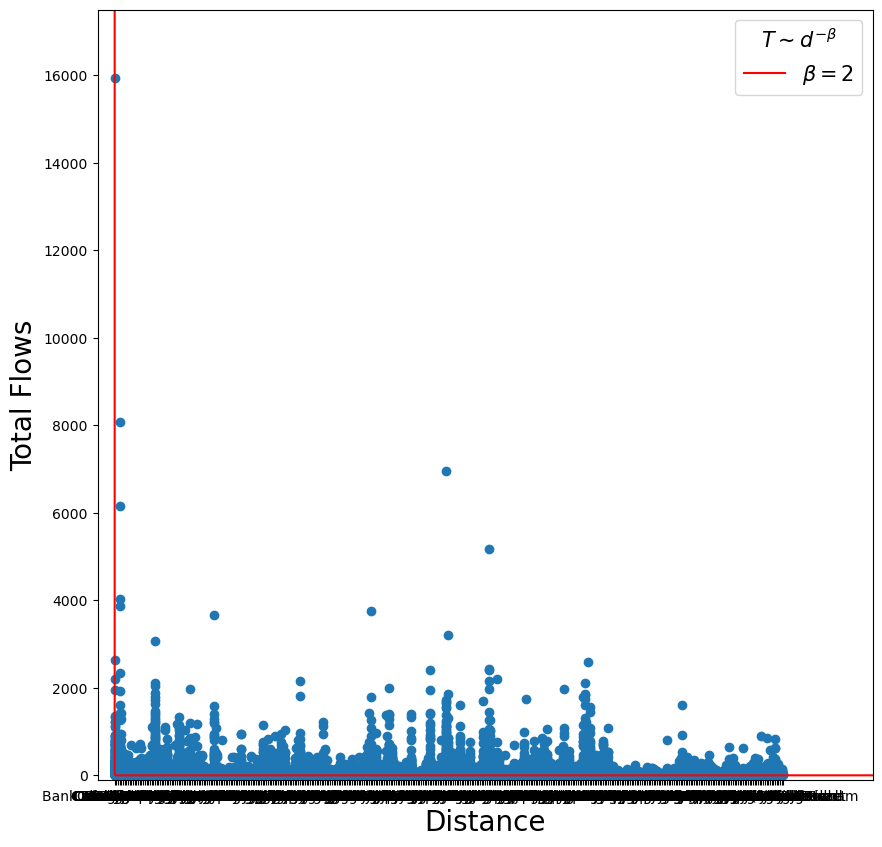

In [7]:
#plot the Total commuter flows denoted by T against distance denoted by d
#and then fit a model line T ~ d^-beta with beta=2

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot #commuting flows vs distance plot
ax.scatter(x = OD_data_1["station_destination"], y=OD_data_1["flows"])
#line plot
line = np.arange(0.0002, 50_000, 0.1)
ax.plot(line, line**-2, color ="r", label = "$\\beta=2$")
#add a legend
ax.legend(title = "$T \\sim d^{-\\beta}$", fontsize = 15, title_fontsize=15)
#axis limits
ax.set_xlim([-10,450])
ax.set_ylim([-100, 17500])
#set the labels
ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

Text(0, 0.5, 'Total Flows')

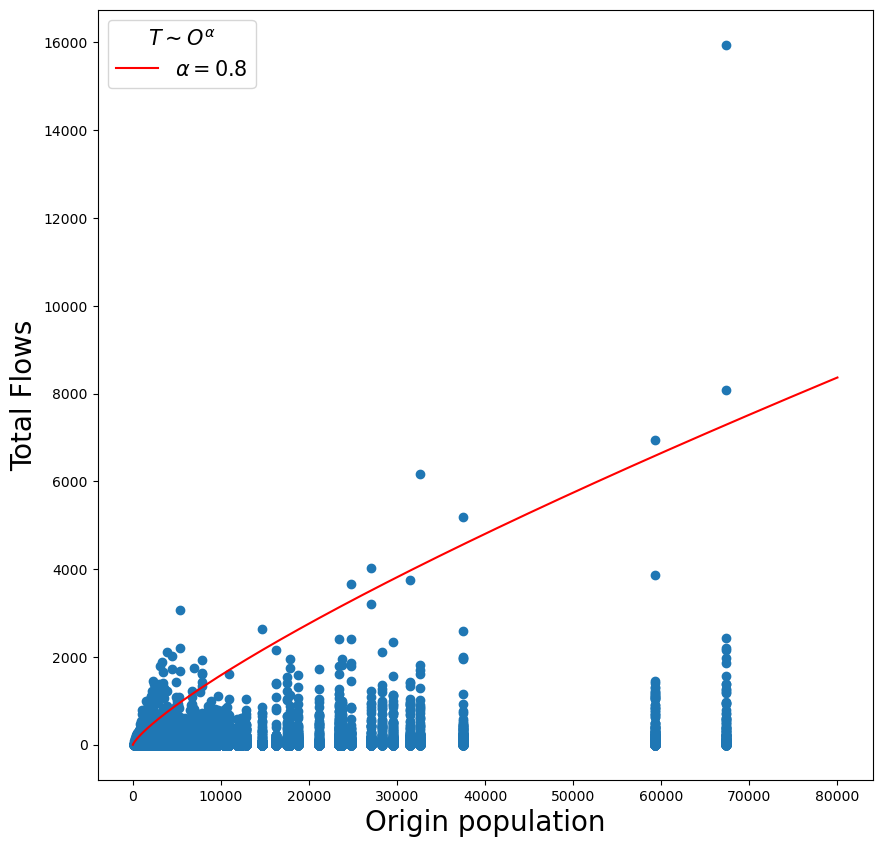

In [8]:
#Let us now look at the behaviour of the flows with respect to the population at the origin denoted by O 
#and then fit a model line T ~ O^alpha, for alpha=1

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = OD_data_1["population"], y=OD_data_1["flows"])
#line plot
line = np.arange(0.0002, 80_000, 0.1)
ax.plot(line, line**0.8, color ="r", label = "$\\alpha=0.8$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim O^{\\alpha}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

Text(0, 0.5, 'Total Flows')

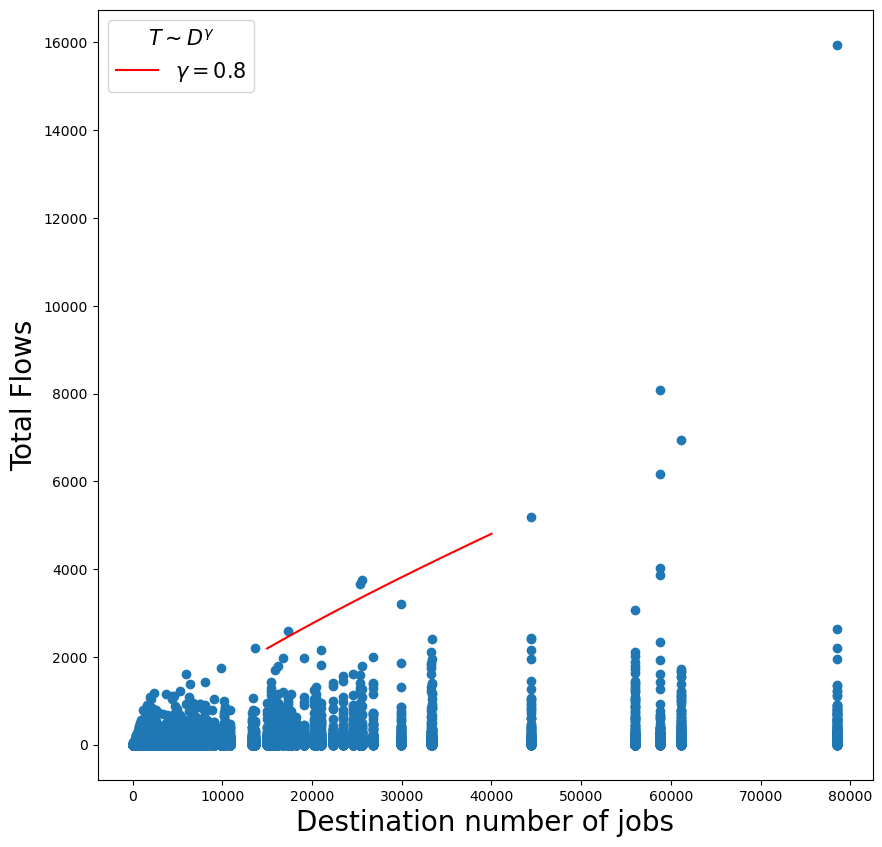

In [9]:
#Now let us look at the behaviour of the flows with respect to the salaries at destination denoted by D
# and then fit a model line  T ~ D^gamma. We will fit a line for gamma=1

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = OD_data_1["jobs"], y=OD_data_1["flows"])
#line plot
line = np.arange(15_000, 40000, 0.1)
ax.plot(line, line**0.8, color ="r", label = "$\\gamma=0.8$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim D^{\\gamma}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Destination number of jobs", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

In [10]:
#set up some variables to hold our parameter values in:
alpha = 0.8
gamma = 0.8
beta = 2
k = 1
T2 = sum(OD_data_1["flows"]) #T2 is T in the equation
#change those parameters to check whether the changes can make a better result

Oi1_alpha = OD_data_1["population"]**alpha
Dj2_gamma = OD_data_1["jobs"]**gamma
dist_beta = OD_data_1["distance"]**-beta
T1 = Oi1_alpha*Dj2_gamma*dist_beta #T1 is Tij in the equation
k = T2/sum(T1)

##how todeal with the interaction between same places, which distance is 0?

In [11]:
dist_beta.value_counts()

5.705453e-08    4
3.656880e-09    4
1.631832e-09    4
3.430698e-09    4
1.704920e-09    4
               ..
2.418663e-09    1
1.982343e-09    1
8.970476e-09    1
2.110224e-08    1
1.099517e-08    1
Name: distance, Length: 44894, dtype: int64

#### 4.2 Get flow estimates

In [12]:
#after get all parameters, multiply them together like equation of unconstrained model
#run the model and store of the new flow estimates in a new column
OD_data_1["unconstrainedEst1"] = round(k*Oi1_alpha*Dj2_gamma*dist_beta, 0)
#convert to integers
OD_data_1["unconstrainedEst1"] = OD_data_1["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(OD_data_1["unconstrainedEst1"])

1539199

In [13]:
# show the results in a matrix
OD_data_1_pivot = OD_data_1.pivot_table(values ="unconstrainedEst1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD_data_1_pivot
#important to have same order of data set before
# totally different

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,996
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,123
Acton Town,NaN,NaN,NaN,2.0,2.0,NaN,4.0,0.0,NaN,2.0,...,2.0,0.0,0.0,4.0,NaN,0.0,NaN,0.0,NaN,971
Aldgate,NaN,NaN,1.0,NaN,228.0,NaN,NaN,0.0,NaN,38.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,11468
Aldgate East,NaN,NaN,1.0,243.0,NaN,NaN,0.0,0.0,NaN,36.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,9365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,3.0,3.0,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,441
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
Woodside Park,NaN,NaN,0.0,2.0,2.0,NaN,0.0,NaN,NaN,2.0,...,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,331


#### 4.3 Testing the goodness-of-fit

In [14]:
CalcRSquared(OD_data_1["flows"], OD_data_1["unconstrainedEst1"])

0.027810647205018364

In [15]:
CalcRMSE(OD_data_1["flows"], OD_data_1["unconstrainedEst1"])

381.296

#### 4.4 Improving the model by calibrating parameters

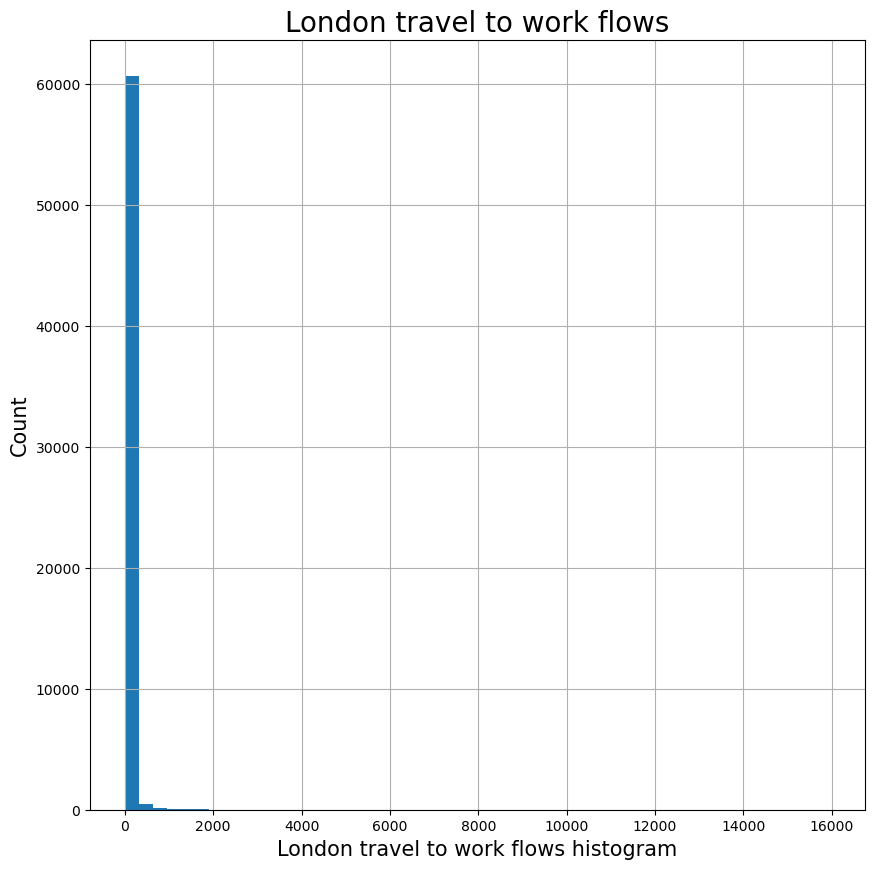

In [16]:
plt.subplots(figsize=(10,10))

plt.hist(OD_data_1["flows"], histtype="stepfilled" , bins = 50)
plt.xlabel("London travel to work flows histogram", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("London travel to work flows", fontsize = 20)
plt.grid(True)

Text(0, 0.5, 'log(Flows)')

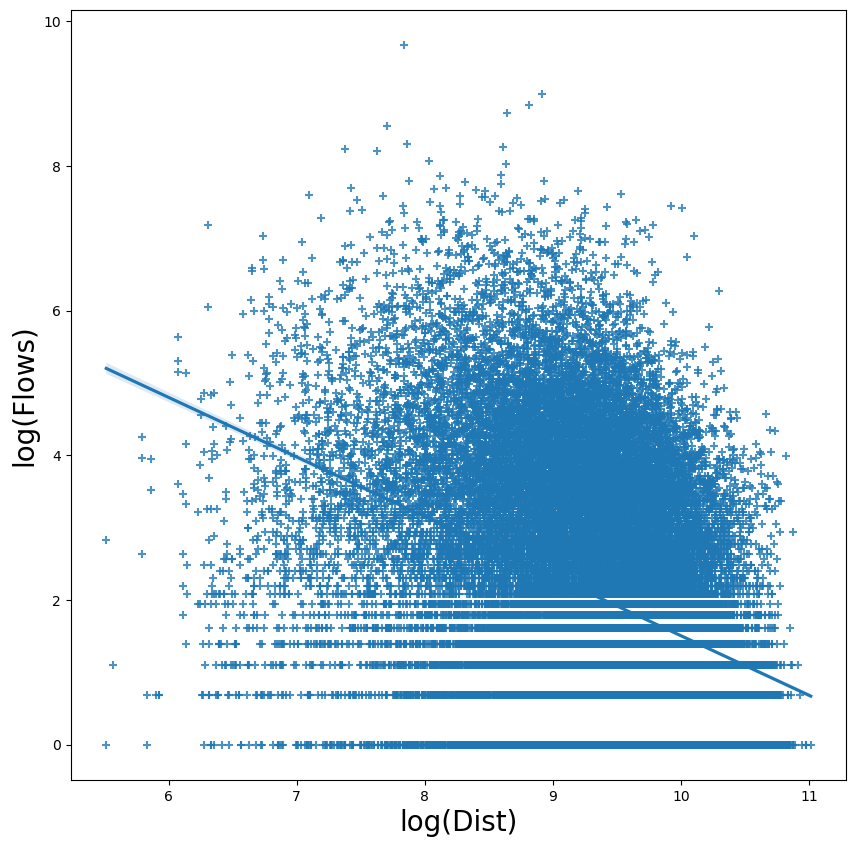

In [17]:
#subset the dataframe to the flows we want
OD_data_1_flows = OD_data_1[["flows", "distance"]]
#remove all 0 values (logarithms can't deal with 0 values)
OD_data_1_flows = OD_data_1_flows[(OD_data_1_flows!=0).all(1)]

#extract the x and y converting to log
x = np.log(OD_data_1_flows["distance"])
y = np.log(OD_data_1_flows["flows"])

#create the subplot
fig, ax = plt.subplots(figsize = (10,10))
#plot the results along with the line of best fit
sns.regplot(x=x, y=y, marker="+", ax=ax)
ax.set_xlabel("log(Dist)", fontsize = 20)
ax.set_ylabel("log(Flows)", fontsize = 20)

In [18]:
#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    OD_data_1[f"log_{x}"] = np.log(OD_data_1[x])
    log_x_vars.append(f"log_{x}")

#create the formula
formula = 'flows ~ log_population + log_jobs + log_distance'
#lnOi; lnDj; lndij
#run the regression
uncosim = smf.glm(formula = formula, 
                  data=OD_data_1, 
                  family=sm.families.Poisson()).fit()

#extract the summary of the constrained model
print(uncosim.summary())
#K = -3.7475; alpha = 0.7325; gamma = 0.7608; beta = 0.6228

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2785e+06
Date:                Mon, 01 May 2023   Deviance:                   2.3848e+06
Time:                        00:59:01   Pearson chi2:                 4.76e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.7475      0.014   -273.

In [19]:
# Recompute unconstrained flows

#first assign the parameter values from the model to the appropriate variables
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]
beta
#be careful with the negative signing of the parameter beta
OD_data_1["unconstrainedEst2"] = np.exp(K 
                                       + alpha*OD_data_1["log_population"] 
                                       + gamma*OD_data_1["log_jobs"] 
                                       - beta*OD_data_1["log_distance"]) #prediction flows

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
OD_data_1["fitted"] = predictions_summary_frame["mean"]
#round the numbers so that we don't get a half of a person
OD_data_1["unconstrainedEst2"] = round(OD_data_1["unconstrainedEst2"], 0)
#convert to integers
OD_data_1["unconstrainedEst2"] = OD_data_1["unconstrainedEst2"].astype(int)
#check that the sum of these estimates make sense
sum(OD_data_1["unconstrainedEst2"])

#turn it into a little matrix and have a look at your handy work
OD_data_1_submat2 = OD_data_1.pivot_table(values ="unconstrainedEst2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD_data_1_submat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,392
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,333
Acton Town,NaN,NaN,NaN,21.0,21.0,NaN,7.0,1.0,NaN,22.0,...,18.0,3.0,6.0,11.0,NaN,2.0,NaN,3.0,NaN,3862
Aldgate,NaN,NaN,7.0,NaN,81.0,NaN,NaN,1.0,NaN,47.0,...,14.0,NaN,8.0,6.0,NaN,3.0,NaN,3.0,NaN,6107
Aldgate East,NaN,NaN,7.0,85.0,NaN,NaN,3.0,1.0,NaN,48.0,...,14.0,3.0,8.0,7.0,NaN,3.0,NaN,3.0,NaN,6470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,26.0,28.0,NaN,NaN,NaN,NaN,25.0,...,14.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3707
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
Woodside Park,NaN,NaN,5.0,18.0,18.0,NaN,2.0,NaN,NaN,21.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,2648


In [20]:
CalcRSquared(OD_data_1["flows"], OD_data_1["unconstrainedEst2"])

0.3211903577361869

In [21]:
CalcRMSE(OD_data_1["flows"], OD_data_1["unconstrainedEst2"])

108.334

In [22]:
#有明显的变好

#### 5. Production-constrained model

#### 5.1 calibrate gamma and beta

In [23]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobs + log_distance - 1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=OD_data_1, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())
#gamma: 0.7686; beta = 0.8781

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Mon, 01 May 2023   Deviance:                   1.8615e+06
Time:                        00:59:14   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

#### 5.2 create model

In [24]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
O_i = pd.DataFrame(OD_data_1.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
OD_data_1 = OD_data_1.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(OD_data_1.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
OD_data_1 = OD_data_1.merge(D_j, on = "station_destination", how = "left" )
# OD_data_1

In [25]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
OD_data_1 = OD_data_1.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
OD_data_1.drop(columns = ["coef"], inplace = True)
#check this has worked
OD_data_1.head()
# #add Oi Dj and alpha-i

C:\Users\zhaol\AppData\Local\Temp\ipykernel_27144\425424700.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,station_origin,station_destination,flows,population,jobs,distance,TotalNoIntra,offset,unconstrainedEst1,log_population,log_jobs,log_distance,unconstrainedEst2,fitted,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,13,6.395262,11.271478,9.003504,50,49.617996,599,78549,3.250242
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,0,6.395262,6.091310,9.049012,1,0.937195,599,442,3.250242
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,1,6.395262,6.499787,8.236275,2,2.121375,599,665,3.250242
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,26,6.395262,10.981421,8.534348,53,53.297014,599,58772,3.250242
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,46,6.395262,9.643939,7.709274,32,32.208586,599,15428,3.250242


In [26]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[398]
beta = prodSim.params[399]

In [43]:
beta

-0.8781191183724283

In [27]:
OD_data_1["prodsimest1"] = np.exp(OD_data_1["alpha_i"]+gamma*OD_data_1["log_jobs"]+beta*OD_data_1["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
OD_data_1.head()

,station_origin,station_destination,flows,population,jobs,distance,TotalNoIntra,offset,unconstrainedEst1,log_population,log_jobs,log_distance,unconstrainedEst2,fitted,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,13,6.395262,11.271478,9.003504,50,49.617996,599,78549,3.250242,55.010681
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,0,6.395262,6.091310,9.049012,1,0.937195,599,442,3.250242,0.986106
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,1,6.395262,6.499787,8.236275,2,2.121375,599,665,3.250242,2.755640
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,26,6.395262,10.981421,8.534348,53,53.297014,599,58772,3.250242,66.457296
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,46,6.395262,9.643939,7.709274,32,32.208586,599,15428,3.250242,49.060970


#### 5.3 Assess the output

In [28]:
#first round the estimates
OD_data_1["prodsimest1"] = round(OD_data_1["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
OD_data_1submat3 = OD_data_1.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD_data_1submat3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [29]:
CalcRSquared(OD_data_1["flows"], OD_data_1["prodsimest1"])

0.3882763950178628

In [30]:
CalcRMSE(OD_data_1["flows"], OD_data_1["prodsimest1"])

102.893

#### 6. Destination-constrained model

#### 6.1 calibrate parameters

In [31]:
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = 'flows ~ station_destination + log_population + log_distance - 1'
#run a production constrained sim
attrSim = smf.glm(formula = attr_form, data=OD_data_1, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1646e+06
Date:                Mon, 01 May 2023   Deviance:                   2.1570e+06
Time:                        00:59:28   Pearson chi2:                 3.65e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [32]:
#get the predictions
predictions = attrSim.get_prediction(OD_data_1[["station_destination", "log_population", "log_distance"]])
predictions_summary_frame = predictions.summary_frame()
OD_data_1["attrsimFitted"] = round(predictions_summary_frame["mean"],0)
#now we can create pivot table to turn paired list into matrix (and compute the margins as well)
OD_data_1submat6 = OD_data_1.pivot_table(values ="attrsimFitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
OD_data_1submat6

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,591.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,586.0
Acton Town,NaN,NaN,NaN,16.0,16.0,NaN,8.0,1.0,NaN,17.0,...,26.0,3.0,5.0,9.0,NaN,2.0,NaN,2.0,NaN,3546.0
Aldgate,NaN,NaN,6.0,NaN,62.0,NaN,NaN,1.0,NaN,36.0,...,19.0,NaN,6.0,5.0,NaN,2.0,NaN,3.0,NaN,5702.0
Aldgate East,NaN,NaN,6.0,68.0,NaN,NaN,3.0,1.0,NaN,37.0,...,20.0,2.0,7.0,5.0,NaN,3.0,NaN,3.0,NaN,6029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,6.0,20.0,21.0,NaN,NaN,NaN,NaN,19.0,...,19.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,3431.0
Woodgrange Park,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.0
Woodside Park,NaN,NaN,5.0,14.0,13.0,NaN,2.0,NaN,NaN,16.0,...,15.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2404.0


In [33]:
CalcRSquared(OD_data_1["flows"], OD_data_1["attrsimFitted"])

0.3499323840939915

In [34]:
CalcRMSE(OD_data_1["flows"], OD_data_1["attrsimFitted"])

106.013

#### 7. Doubly constrained model

#### 7.1 inversed power model

In [35]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = 'flows ~ station_destination + station_origin + log_distance - 1'
#run a doubly constrained sim
#inversed power model
doubSim = smf.glm(formula = dbl_form, data=OD_data_1, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim.summary())
# beta = 0.9096

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.7074e+05
Date:                Mon, 01 May 2023   Deviance:                   1.7693e+06
Time:                        01:00:19   Pearson chi2:                 2.47e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [36]:
#get the estimates
OD_data_1["doubsimfitted"] = np.round(doubSim.mu)
#here's the matrix
cdatasubmat7 = OD_data_1.pivot_table(values ="doubsimfitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
cdatasubmat7

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,15.0,15.0,NaN,11.0,1.0,NaN,17.0,...,30.0,3.0,5.0,12.0,NaN,2.0,NaN,2.0,NaN,3747.0
Aldgate,NaN,NaN,2.0,NaN,42.0,NaN,NaN,0.0,NaN,19.0,...,7.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2873.0
Aldgate East,NaN,NaN,2.0,49.0,NaN,NaN,1.0,0.0,NaN,21.0,...,8.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,31.0,33.0,NaN,NaN,NaN,NaN,29.0,...,29.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,5.0,18.0,17.0,NaN,3.0,NaN,NaN,22.0,...,21.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [37]:
cdatasubmat7 = OD_data_1.pivot_table(values ="doubsimfitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
cdatasubmat7

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,15.0,15.0,NaN,11.0,1.0,NaN,17.0,...,30.0,3.0,5.0,12.0,NaN,2.0,NaN,2.0,NaN,3747.0
Aldgate,NaN,NaN,2.0,NaN,42.0,NaN,NaN,0.0,NaN,19.0,...,7.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2873.0
Aldgate East,NaN,NaN,2.0,49.0,NaN,NaN,1.0,0.0,NaN,21.0,...,8.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,31.0,33.0,NaN,NaN,NaN,NaN,29.0,...,29.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,5.0,18.0,17.0,NaN,3.0,NaN,NaN,22.0,...,21.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [38]:
CalcRSquared(OD_data_1["flows"],OD_data_1["doubsimfitted"])

0.4076853229296066

In [39]:
CalcRMSE(OD_data_1["flows"],OD_data_1["doubsimfitted"])

101.335

#### 8. Tweaking model

#### 8.1 Distance decay

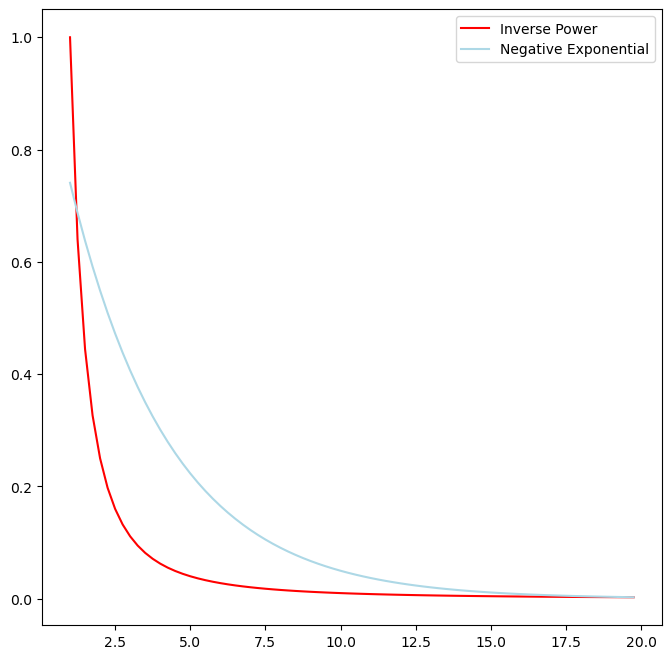

In [40]:
# Graph the distance decay parameters to get a feel for how they work.
xs = np.arange(1.0,20.0,0.25)
# inverse square power
y_inv_power = np.power(xs,-2)
# negative exponential, beta = 0.3
y_neg_exp_point3 = np.exp(-0.3*xs)

# Now a plot.
f, ax = plt.subplots(figsize=(8,8))
ax.plot(xs,y_inv_power, label = "Inverse Power", color = "red")
ax.plot(xs,y_neg_exp_point3, label = 'Negative Exponential', color = "lightblue")
ax.legend();

#### 8.1.1 Negative exponential cost function

In [41]:
# Run a doubly constrained SIM with a negative exponential cost function.
doubsim_form = "flows ~ station_origin + station_destination + distance -1" ##simplify the -beta*log(dij) to -beta*dij
doubsim1 = smf.glm(formula=doubsim_form, data = OD_data_1, family = sm.families.Poisson()).fit()
print(doubsim1.summary())
#beta = 0.0002

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Mon, 01 May 2023   Deviance:                   1.5299e+06
Time:                        01:01:12   Pearson chi2:                 2.02e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [45]:
OD_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61413 entries, 0 to 61412
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61413 non-null  object 
 1   station_destination  61413 non-null  object 
 2   flows                61413 non-null  int64  
 3   population           61413 non-null  int64  
 4   jobs                 61413 non-null  int64  
 5   distance             61413 non-null  float64
 6   TotalNoIntra         61413 non-null  int64  
 7   offset               61413 non-null  float64
 8   unconstrainedEst1    61413 non-null  int32  
 9   log_population       61413 non-null  float64
 10  log_jobs             61413 non-null  float64
 11  log_distance         61413 non-null  float64
 12  unconstrainedEst2    61413 non-null  int32  
 13  fitted               61413 non-null  float64
 14  O_i                  61413 non-null  int64  
 15  D_j                  61413 non-null 

In [46]:
cdatasubmat8 = OD_data_1.pivot_table(values ="doubsimfitted", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
cdatasubmat8

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,15.0,15.0,NaN,11.0,1.0,NaN,17.0,...,30.0,3.0,5.0,12.0,NaN,2.0,NaN,2.0,NaN,3747.0
Aldgate,NaN,NaN,2.0,NaN,42.0,NaN,NaN,0.0,NaN,19.0,...,7.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2873.0
Aldgate East,NaN,NaN,2.0,49.0,NaN,NaN,1.0,0.0,NaN,21.0,...,8.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,31.0,33.0,NaN,NaN,NaN,NaN,29.0,...,29.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,5.0,18.0,17.0,NaN,3.0,NaN,NaN,22.0,...,21.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [ ]:
# OD_data_1_mat.loc[:,"Wembley Park"].head(25)

In [48]:
CalcRSquared(OD_data_1["flows"],OD_data_1["doubsimfitted"])

0.4076853229296066

In [49]:
CalcRMSE(OD_data_1["flows"],OD_data_1["doubsimfitted"])

101.335

#### 9. Iterations

In [ ]:
# since calculate Ais need Bj, and calculate Bjs need Ai, so we need a loop to calculate

#create some Oi and Dj columns in the dataframe and store row and column totals in them:
O_i = pd.DataFrame(OD_data_1.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
OD_data_1 = OD_data_1.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(OD_data_1.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
OD_data_1 = OD_data_1.merge(D_j, on = "station_destination", how = "left" )

In [ ]:

# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

#### 9.1 inverse power model

In [ ]:
#Using the function above we can calculate 𝐴𝑖 and 𝐵𝑗 for the previous Poisson model by plugging in the estimate of beta that we generated.

# Use the beta we got from the inverse power model
beta = -doubSim.params[-1] #use the same beta that got from the poisson distribution before to calculate Ai and Bj
# Get the balancing factors.
OD_data_1 = balance_doubly_constrained(OD_data_1,'station_origin','station_destination','O_i','D_j','distance',-beta,'power')

# Now predict the model again using the new Ai and Dj fields.
OD_data_1['SIM_est_pow'] = np.round(OD_data_1['O_i'] * OD_data_1['Ai_new'] * OD_data_1['D_j'] * OD_data_1['Bj_new'] * 
                                   np.exp(np.log(OD_data_1['distance'])*-beta))
#apply the entropy function
# Check out the matrix to check the results
pd.pivot_table(OD_data_1,values='SIM_est_pow',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)


In [ ]:
# Use the beta we got from the negative exponential model
beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
OD_data_1 = balance_doubly_constrained(OD_data_1,'station_origin','station_destination','O_i','D_j','distance',-beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
OD_data_1['SIM_est_exp'] = np.round(OD_data_1['O_i'] * OD_data_1['Ai_exp'] * OD_data_1['D_j'] * OD_data_1['Bj_exp'] * 
                                   np.exp(OD_data_1['distance']*-beta))
# Check out the matrix
pd.pivot_table(OD_data_1,values='SIM_est_exp',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)
# which has more accurate simulation result with the negative exponential model

In [ ]:
CalcRSquared(OD_data_1["flows"],OD_data_1["SIM_est_exp"])

In [ ]:
CalcRMSE(OD_data_1["flows"],OD_data_1["SIM_est_exp"])

### Part IV

In [ ]:
#create a new job function to change the value with
#station_destination == "Canary Wharf" to 50% of original number of jobs
def new_jobs(row):
    if row["station_destination"] == "Canary Wharf":
        val = 0.5*row["jobs"]
    else:
        val = row["jobs"]
    return val

OD_data_1["jobsSA"] = OD_data_1.apply(new_jobs, axis =1)#applying to the data set
#check the result to make sure it has been applied
OD_data_1["jobsSA"] = OD_data_1["jobsSA"].astype(int)
OD_data_1.head()

In [ ]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobsSA + distance - 1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=OD_data_1, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())